Compare different flows

# Importing Dependencies

In [1]:
import constants as const
# import progressbar as pb
# from display import pltDisplay
import utils
import logging
# import time
import numpy as np
import pandas as pd
from pathlib import Path
# import os
import cv2
import matplotlib.pyplot as plt
# import librosa
# import librosa.display
# from scipy import signal
import IPython.display as ipd
# import math
# from PIL import Image
# import scipy as sp
# import dtale # for interaction with pandas database
# import soundfile as sf
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
log_file = const.logs_path + 'flowComparison.log'
logging.basicConfig(
    format='%(asctime)s %(message)s', filemode='a',
    filename=log_file, encoding='utf-8',
    level=logging.INFO, force=True
)

# Importing Dataset

In [4]:
df = pd.read_csv(Path(const.csv_path, 'dataset.csv'))

# Frame

In [5]:
# Dimensions of generated images
IMG_HEIGHT = IMG_WIDTH = const.IMG_HEIGHT

# MAX dimensions of bounding box
MAX_WIDTH = MAX_HEIGHT = const.MAX_WIDTH

In [6]:
# Set the seed value for experiment reproducibility.
SEED = 42
# tf.random.set_seed(SEED)
np.random.seed(SEED)

In [7]:
EMOTIONS_LABELS = const.EMOTIONS_LABELS_SORTED
video_format_codec = const.VIDEO_FORMAT_CODECS

In [16]:
# Consider 3 random actors
rng = np.random.default_rng(SEED)
idx1, idx2, idx3 = rng.choice(25, size=3, replace=False)

print(f'Actors idx:{idx1, idx2, idx3}')

Actors idx:(16, 2, 18)


In [17]:
# fixed repetition because considered not influent for evaluation
a = utils.video_search(
    df, actors=[idx1], intensities=[1], statements=[1], repetitions=[1]
)
b = utils.video_search(
    df, actors=[idx2], intensities=[1], statements=[1], repetitions=[1]
)
c = utils.video_search(
    df, actors=[idx3], intensities=[1], statements=[1], repetitions=[1]
)

In [19]:
df_11 = [a, b, c]
df_11 = pd.concat(df_11)

In [20]:
df_11.reset_index(drop=True, inplace=True)

In [22]:
df_sampled = df_11

In [25]:
# Sample the database

sample_fraction = 0.006

df_sampled, df_remaining = train_test_split(
    df, train_size=sample_fraction, random_state=SEED, stratify=df.emotion
)
print(
    f'Length of sample array is {len(df_sampled)} element,\
    {sample_fraction:.1%} of {len(df)}'
)

Length of sample array is 8 element,    0.6% of 1440


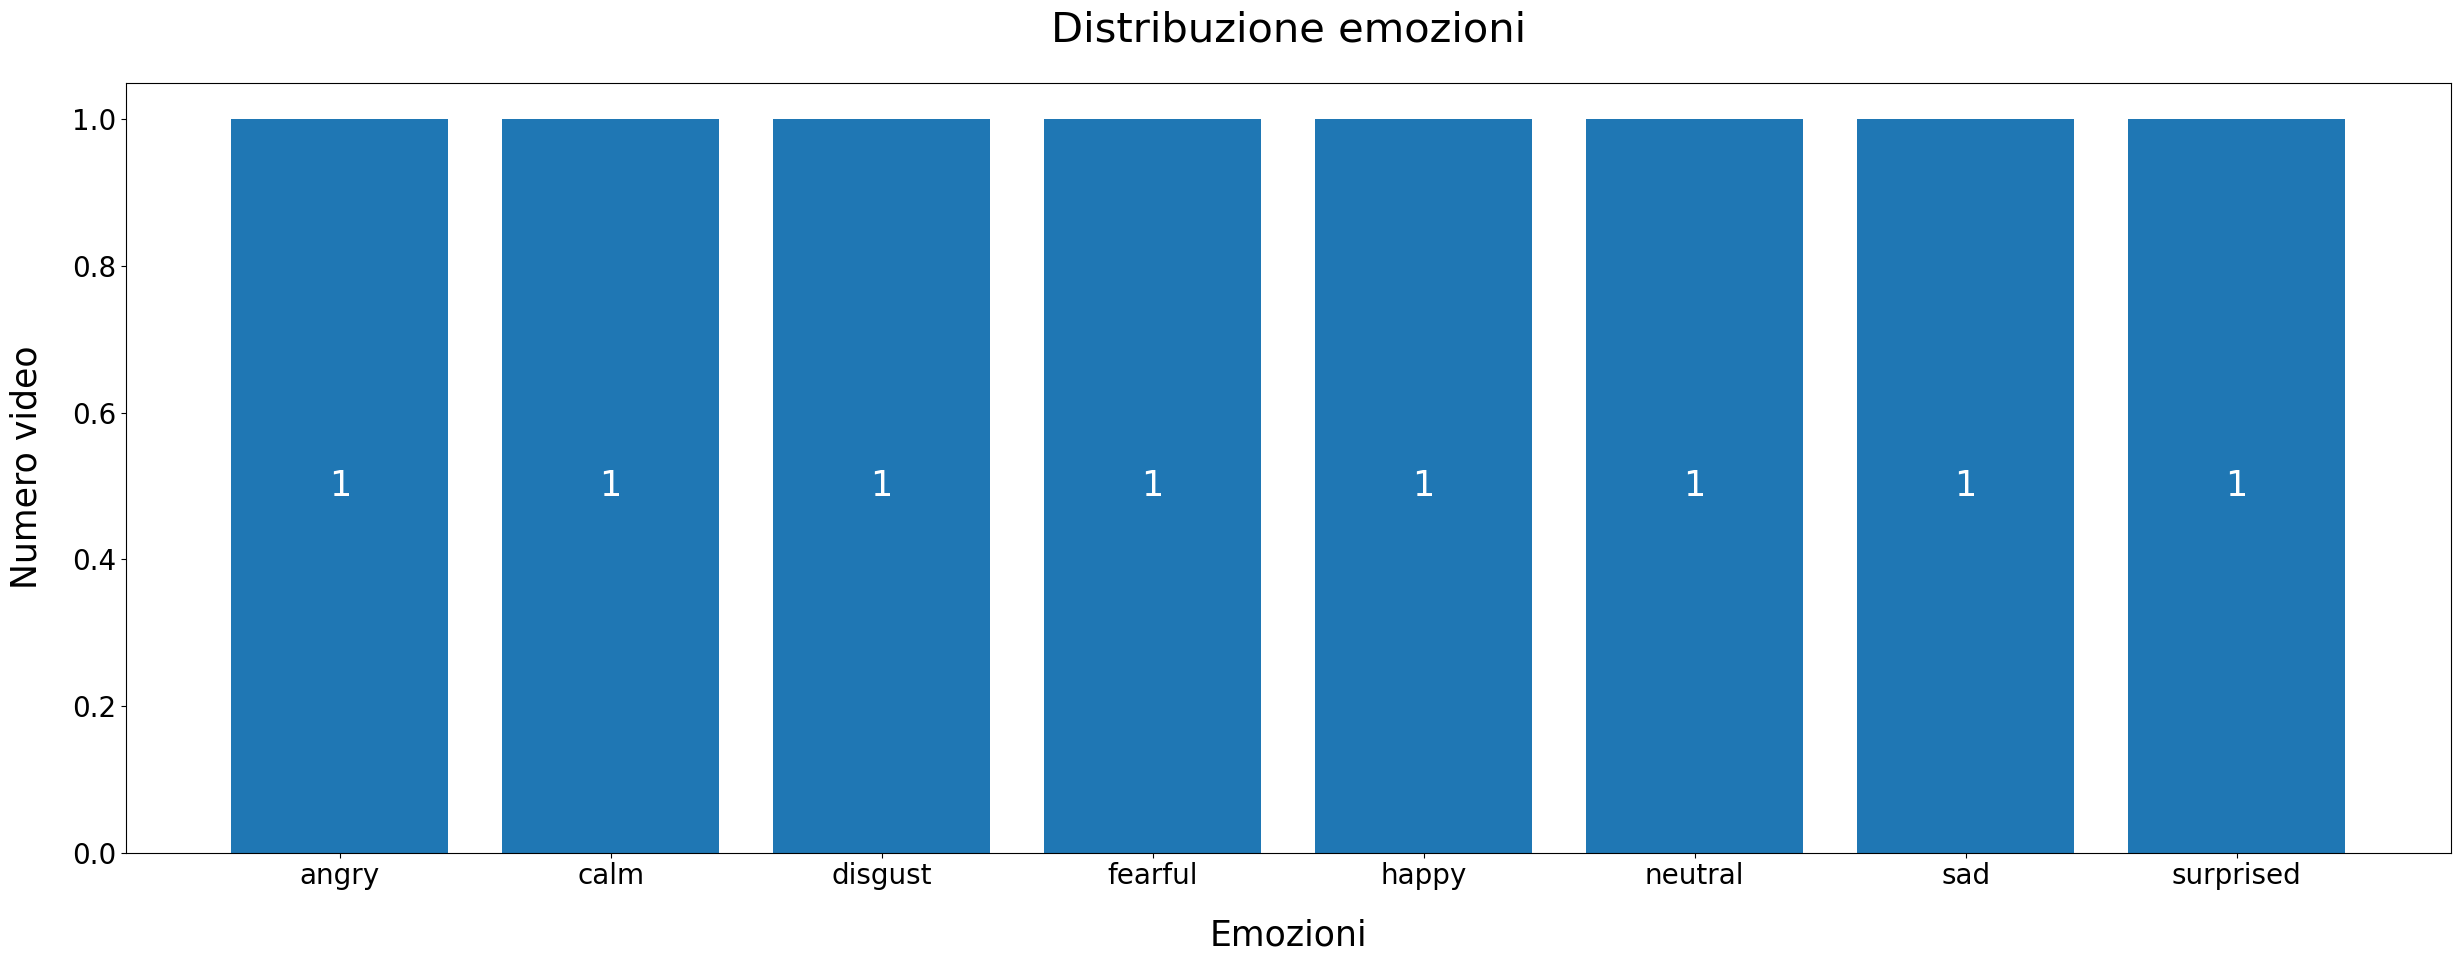

In [26]:
# Emotion distribution graph

fig = plt.figure(figsize=(30, 10))

x_mod = np.arange(1, 9)
y_mod = [
    len(df_sampled[df_sampled['emotion'] == EMOTIONS_LABELS])
    for EMOTIONS_LABELS in x_mod
]

bar_plot = plt.bar(x_mod, y_mod)
plt.title('Distribuzione emozioni', fontsize=30, pad=30)
plt.ylabel('Numero video', fontsize=25, labelpad=20)
plt.xlabel('Emozioni', fontsize=25, labelpad=20)
plt.xticks(
    np.arange(1, len(x_mod) + 1),
    [EMOTIONS_LABELS[idx] for idx, x in enumerate(x_mod)],
    fontsize=20
)
plt.yticks(fontsize=20)

# Write numbers on the bars
plt.bar_label(bar_plot, label_type='center', fontsize=25, color='white')
plt.show()

In [27]:
utils.estimated_space_occupation(len(df_sampled), str(IMG_WIDTH))

[480, '3.2 MB']

## Find differences in two videos

The following code is used to compare two different videos. It takes in input two path to videos, and returns another video
containing the difference between the two.

A video is composed by a series of frame, that are images. So we have to compare each frame of a video to each frame of the other, using a difference measure.

In [28]:
from reload import reload_module
reload_module(utils)

Module <module 'utils' from 'C:\\Users\\mic-c\\Documents\\GitHubRepo\\CNN-emotion-recognition\\utils.py'> reloaded


## *def compare_images*

In [29]:
def compare_images(image_1, image_2, color=cv2.IMREAD_UNCHANGED):
    # Take two images and return the difference
    im_1 = image_1
    im_2 = image_2

    # if input is a string read image
    if isinstance(image_1, str):
        im_1 = cv2.imread(image_1, color)

    if isinstance(image_2, str):
        im_2 = cv2.imread(image_2, color)

    assert im_1.shape == im_2.shape

    abs_diff = cv2.absdiff(im_1, im_2)

    return abs_diff

In [30]:
test_folder_gen = Path(const.frames_path).glob('angry/*')

# test_folder_path = f'{test_frames_path}{test_folder}'
# test_folder_files = os.listdir(test_folder_path)

test_image_1 = str(next(test_folder_gen))
test_image_2 = str(next(test_folder_gen))

In [31]:
im_result = compare_images(test_image_1, test_image_2)
im_result.shape

(128, 128, 3)

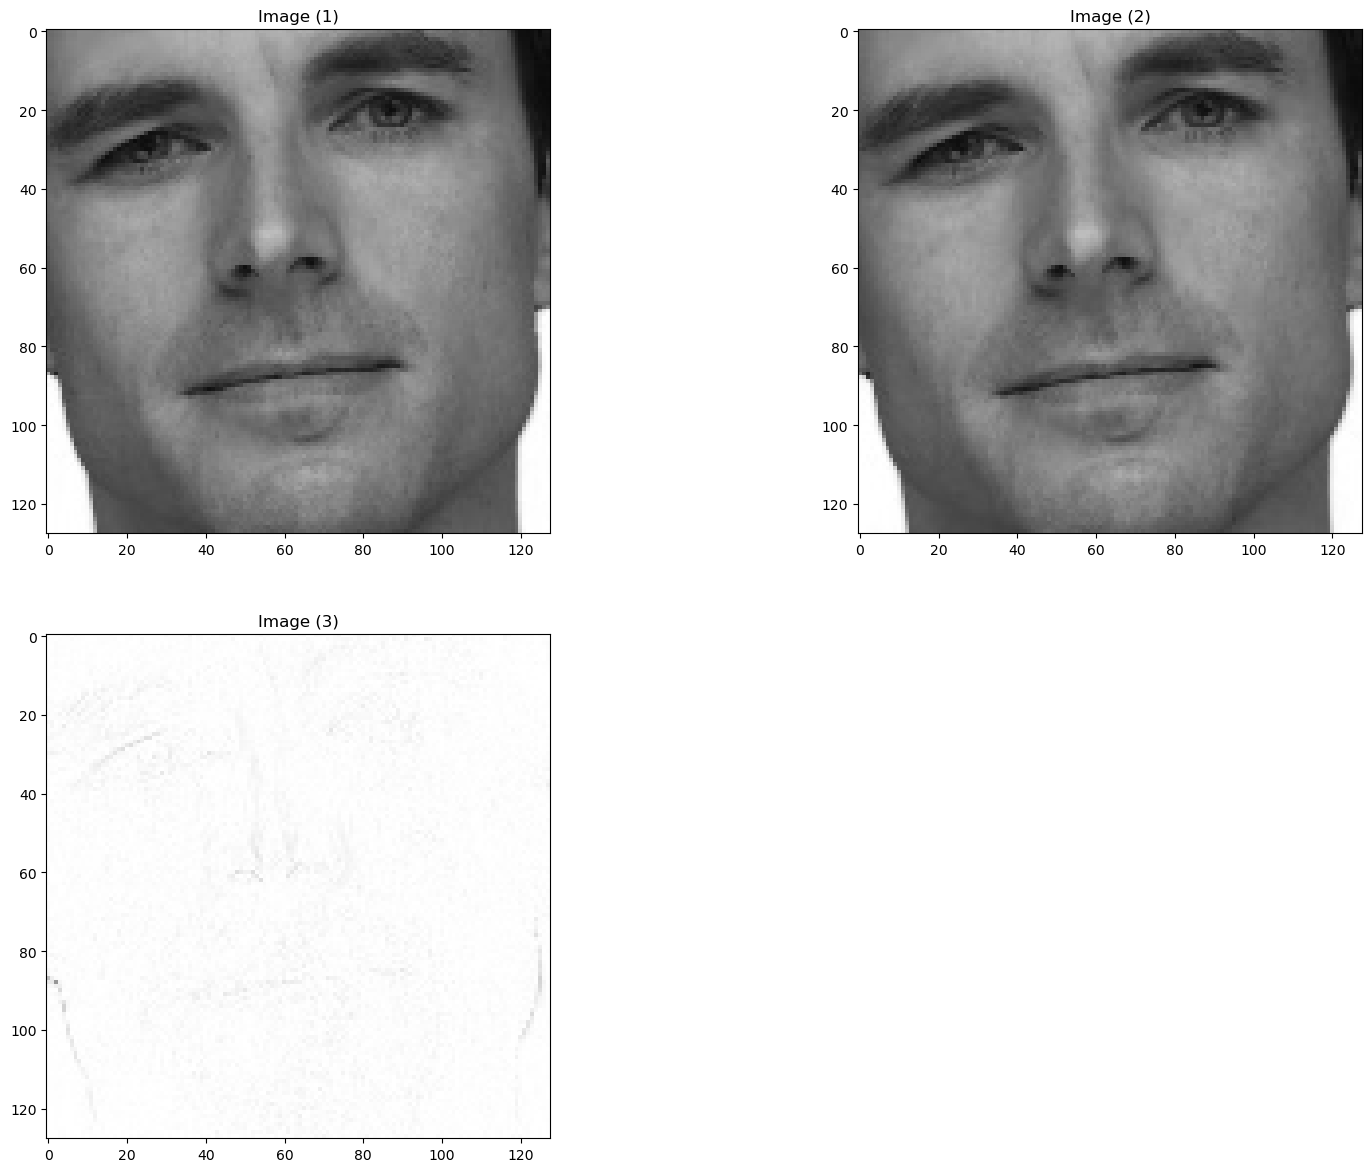

In [41]:
img_1 = cv2.imread(test_image_1)
# img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

img_2 = cv2.imread(test_image_2)
# img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

im_result = compare_images(img_1, img_2)
utils.show_images([img_1, img_2, 255 - im_result], cols=2)

## *def compare_videos*

In [53]:
def compare_videos(video_1, video_2, video_path=None):

    ar_1 = []
    ar_2 = []
    ar_3 = []

    path_1 = video_1
    cap_1 = cv2.VideoCapture(path_1)

    success, image = cap_1.read()

    count = 0
    while success:
        ar_1.append(image)
        success, image = cap_1.read()
        count += 1
    cap_1.release()

    path_2 = video_2
    cap_2 = cv2.VideoCapture(path_2)

    success, image = cap_2.read()
    count = 0
    while success:
        ar_2.append(image)
        success, image = cap_2.read()
        count += 1
    cap_2.release()

    if (ar_1[0][0]).shape != (ar_2[0][0]).shape:
        raise ValueError('Array do not have same shape')

    img_shape = list(ar_1[0].shape)

    ar = [ar_1, ar_2]

    # sort the list in place based on number of frame per video (length of video)
    ar.sort(key=len)

    for f_ar_0, f_ar_1 in zip(ar[0], ar[1]):

        f_res = compare_images(f_ar_0, f_ar_1)
        ar_3.append(f_res)

    len_diff = len(ar[1]) - len(ar[0])

    for x in range(len_diff):
        img = np.zeros(img_shape, dtype=np.uint8)
        img = np.random.randint(0, 256, (img_shape[0], img_shape[1], 3), dtype='uint8')
        ar_3.append(img)

    fps = 30
    duration = 5

    video_name = f'{Path(video_1).stem}_{Path(video_2).stem}'
    video_suffix = 'mp4'

    if video_path is not None:
        video_suffix = Path(video_path).suffix[1:]
        video_name = Path(video_path).with_suffix('')

        if video_suffix not in video_format_codec.keys():
            print('ERROR: extension not available. Switching to default mp4')
            video_suffix = 'mp4'

    video_filename = f'{video_name}.{video_suffix}'

    out = cv2.VideoWriter(
        video_filename, cv2.VideoWriter_fourcc(*video_format_codec[video_suffix]),
        fps, (img_shape[1], img_shape[0]), True
    )

    for x in ar_3:
        out.write(x)

    out.release()
    cv2.destroyAllWindows()

    return [video_filename, ar_1, ar_2, ar_3]

In [54]:
t = utils.video_search(df_11, intensities=[1], statements=[1])
idx1, idx2 = rng.choice(len(t), 2, replace=False, shuffle=False)
print(idx1, idx2)
v1 = t.iloc[idx1]
v1 = utils.get_full_path(v1)
v2 = t.iloc[idx2]
v2 = utils.get_full_path(v2)

16 4


In [55]:
res = compare_videos(v1, v2, 'test/video_comparison.mp4')

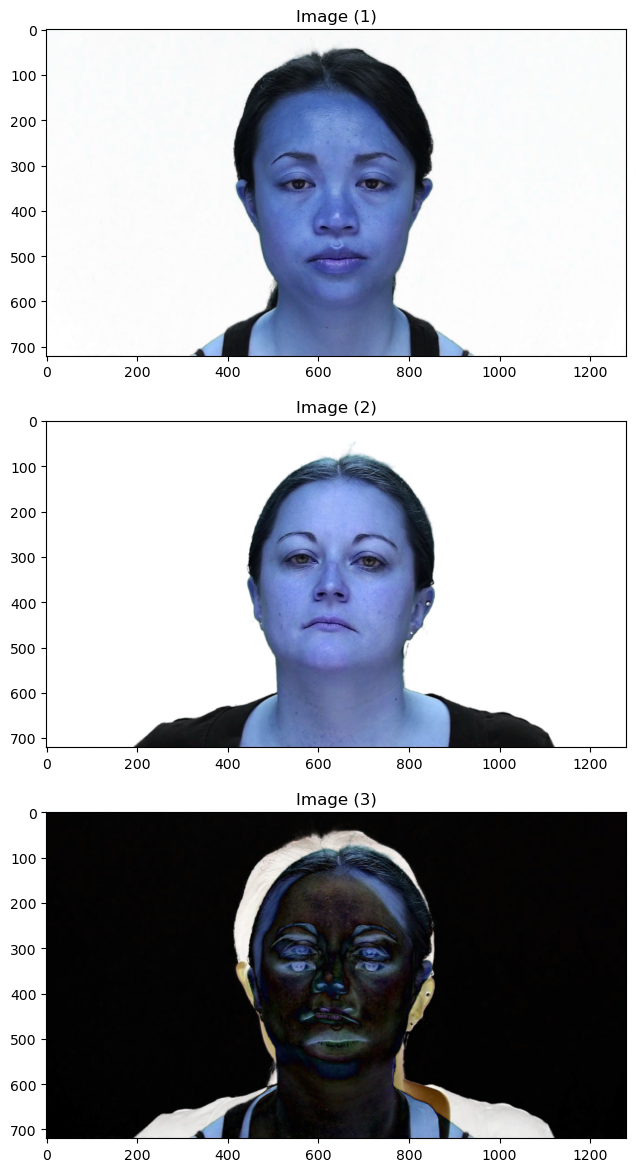

In [56]:
idx = rng.integers(len(res[0]))

# convert color
im_1 = cv2.cvtColor(res[1][idx], cv2.COLOR_BGR2RGB)
im_2 = cv2.cvtColor(res[2][idx], cv2.COLOR_BGR2RGB)
im_3 = cv2.cvtColor(res[3][idx], cv2.COLOR_BGR2RGB)

utils.show_images([im_1, im_2, im_3])

In [33]:
v1 = Path('./FlowGridSearch/Run_1/01-01-07-02-01-01-03/video_30.mp4')
v2 = Path('./FlowGridSearch/Run_20/01-01-07-02-01-01-03/video_30.mp4')

In [57]:
res = compare_videos(str(v1), str(v2), 'test/flow_comp.mp4')

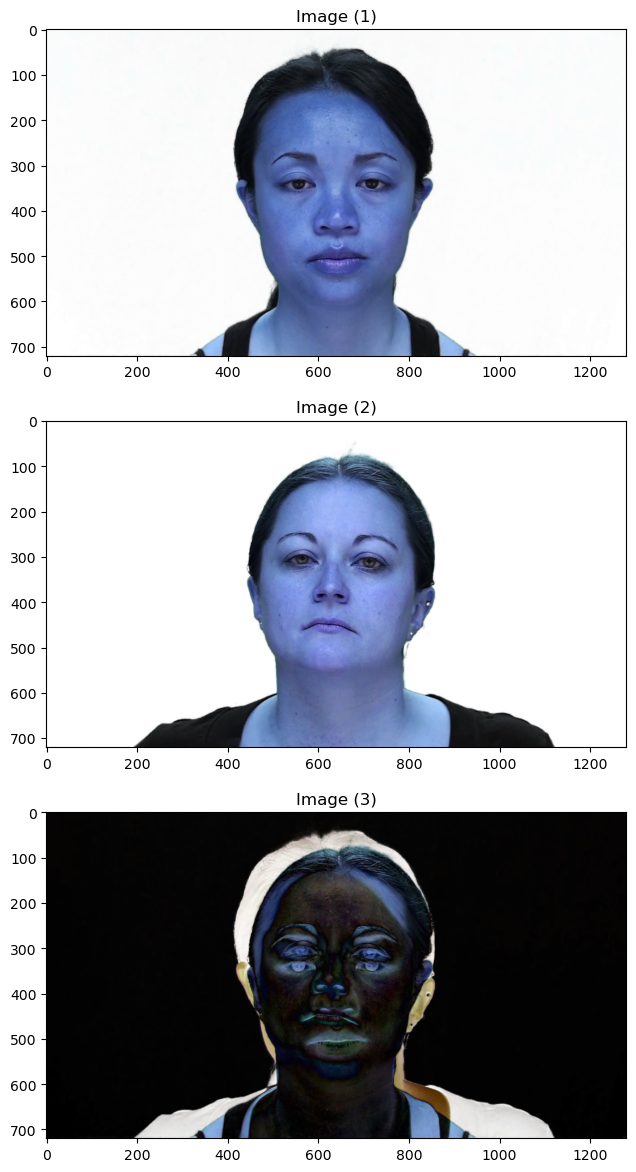

In [58]:
idx = rng.integers(len(res[0]))

# convert color
im_1 = cv2.cvtColor(res[1][idx], cv2.COLOR_BGR2RGB)
im_2 = cv2.cvtColor(res[2][idx], cv2.COLOR_BGR2RGB)
im_3 = cv2.cvtColor(res[3][idx], cv2.COLOR_BGR2RGB)

utils.show_images([im_1, im_2, im_3])

In [60]:
ipd.Video('test/flow_comp.mp4', width=300)

In [61]:
vidcap = cv2.VideoCapture(res[0])

utils.video_info(vidcap)

while (True):
    ret, frame = vidcap.read()
    if not ret:
        print('No frames grabbed!')
        break

    cv2.imshow('Frame', frame)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

vidcap.release()
cv2.destroyAllWindows()


    Frame Width: 1280
    Frame Height: 720
    Frame Rate: 30
    # Current position of video  (ms): 0
    Numbers of frame: 119
    
No frames grabbed!


In [62]:
logging.shutdown()

-------------------------------------------------------------